In [4]:
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import random
import seaborn  as sns
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
print("Done!")

ImportError: C extension: None not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [2]:
"""Variables and parameters """
#these are values used to generate noise
NOISE_MEAN = 0
NOISE_STD_DEV = 10

SAMPLING_RATE=0.31233 #in ns
FREQUENCY=1/(SAMPLING_RATE*10**(-9)) #in Hz


COMMON_THRESHOLD = 3000 #trigger threshold --not used here
DELAY_PERIOD= 70 #the delay of time to wait when a threshold is exceeded -- not used here
LOW_AMPLITUDE, HIGH_AMPLITUDE = 50, 100 # the upper limit and lower limit of the amplitudes of the random pulses


ENVELOPE_RANGE=10
PLOT_Y_LIMS=200,200
PULSE_LIKELIHOOD= 4 #probability of occurance of random pulses (Higher makes it less probable, n is around 1 occurance per n cycles)
graph_size_ns=400
max_size= 1000 #the maximum number of points in the signal arrays kept at any time (this includes t_axis) (to protect the RAM)
n_of_channels=4 #number of channels and plots
PULSE_DURATION_NS=25 #the length of each generated signal/ pulse if less than 30 it would clearly cutoff the signals

SUPERPOSITION_FACTOR= 1 #the maxiumum number of super-imposed signals in each channel

print("Done!")


Done!


In [3]:
def samples_to_ns(samples, rate=SAMPLING_RATE):
    return round(samples*rate)
def ns_to_samples(duration, rate=SAMPLING_RATE):
    return round(duration/rate)

PULSE_DURATION=ns_to_samples(PULSE_DURATION_NS)


In [4]:
"""Ice properties and caracteristics of the geometry of the channels"""

n_ice= 1.78  #index of refraction in ice
vertical_seperation= 1 #distance betwwen channel in meters
channel_weights= [1,1,1,1] #the weight attributed to each channel
c= 299792458 #speed of light in a vaccum in m/s



In [5]:
def angle_delay_time(index, distance, speed, angle ):
    angle=np.deg2rad(angle)

    #this is the offset in time of each signal that is generated
    time_delays= index * distance * np.sin(angle) / speed
    return time_delays

incident_angle=random.randint(0,360)
print(incident_angle, angle_delay_time(n_ice,vertical_seperation, c, incident_angle))

319 -3.895311707951983e-09


In [6]:
"""Classes """
class WaveAmplitude: #class for generating random numbers used as the amplitude of a signal
    def __init__(self, value=0 ):
        self.value=np.random.randint(LOW_AMPLITUDE, HIGH_AMPLITUDE)
    def generate_new(self):
        self.value=np.random.randint(LOW_AMPLITUDE, HIGH_AMPLITUDE)

class TimeDelay: #class for generating random numbers used as the amplitude of a signal
    def __init__(self, angle=0, time_delay_ns=0 ):
        self.angle=0
        self.time_delay_ns=0
    def set_ang(self, ang):
        self.angle=ang
        self.time_delay_ns=angle_delay_time(n_ice,vertical_seperation, c, ang)*10**9
    def set_new(self):
        ang=random.randint(0,360)
        self.angle=ang
        self.time_delay_ns=angle_delay_time(n_ice,vertical_seperation, c, ang)*10**9


class WaveProgression: #this class is for counters used in generating the pulses
    def __init__(self, value:int=0):
        self.value=0
    def plus_one(self):
        self.value +=1
    def reset(self):
        self.value=0
    def change(self,const):
        self.value=const


class PulseExistence(): #This is used for knowing if a pulse is happening and the code will keep generating the pulse if the value is True
    def __init__(self, state:bool=False):
        self.state=False
    def set_true(self):
        self.state=True
    def set_false(self):
        self.state=False

print("Done!")

Done!


In [7]:
"""Function """

def display_n_plots_envelope(t_axis, signals, threshold, plot_size, envelopes, PLOT_Y_LIMS, envelope_range, state, name):
    ind_plot_size=ns_to_samples(plot_size)
    if (t_axis[-1]//SAMPLING_RATE) % ind_plot_size  == 0:
        print("plot n°: ", t_axis[-1] // plot_size)
        print("--------------------------------------------------------")
        fig, axs = plt.subplots(4, 1, figsize=(12, 12))

        upper_index = (envelope_range // 2)
        y_limits = (-PLOT_Y_LIMS[0], PLOT_Y_LIMS[1])

        if t_axis[-1] // plot_size > 1:
            bound_1 = envelope_range + upper_index
            bound_2 = envelope_range
            t_bound = plot_size + upper_index
        else:
            bound_1 = upper_index
            bound_2 = 1
            t_bound = plot_size

        for i, ax in enumerate(axs.flat):
            ax.plot(t_axis[-ind_plot_size:], signals[i][-ind_plot_size:], label=f'Channel {i}')
            ax.set_title(f'Channel {i}', fontsize=10)
            ax.set_xlabel('Time (ns)', fontsize=9)
            ax.set_ylabel('Voltage (mV)', fontsize=9)
            ax.set_ylim(y_limits)
            ax.axhline(y=threshold, lw=1, color='r', linestyle='--')
            ax.grid(True, lw=0.5)
            ax.label_outer()

        fig.suptitle('4 Power String Channels', fontsize=22)
        #plt.tight_layout(rect=[0, 0, 1, 0.96])
        if state=="save":
            plt.savefig(f'plot_{name}_{round(t_axis[-1])}.png')
            plt.clf()
        else:
            plt.show()


def display_and_phase_channels(t_axis, signals, plot_size_ns, mode="show", name="phased_plot"):
    """
    Plots and phases 4 channels by shifting their waveforms by a number of indices.

    Parameters:
    - t_axis: time axis (shared by all channels)
    - signals: list of 4 signal arrays (one per channel)
    - plot_interval_ns: time interval (in ns) at which to trigger a plot
    - shift_indices: list of 4 integers indicating how much to shift each channel in index units
    - mode: "save" or "show"
    - name: base name for saved file
    """
    ind_plot_size=ns_to_samples(plot_size_ns)
    delays_ns=[150,4,10,100]

    # Only plot if we're at a multiple of the interval
    if (t_axis[-1] // SAMPLING_RATE) % ind_plot_size == 0:
        print("Phased plot at t =", t_axis[-1])
        print("--------------------------------------------------------")
        delays_samples=[ns_to_samples(t) for t in delays_ns]
        max_shift_samples= np.max(delays_samples)
        len_pads= len(t_axis[-ind_plot_size:])+max_shift_samples
        padded_time=np.append(t_axis[-ind_plot_size:-1], np.arange(t_axis[-1],t_axis[-1]+np.max(delays_ns),step=SAMPLING_RATE))
        fig, axs = plt.subplots(4, 1, figsize=(12, 12))

        for i, ax in enumerate(axs.flat):
            signal = signals[i]
            shift = delays_samples[i]

            # Grab the last portion of the signal
            sig_trimmed = signal[-ind_plot_size:]

            # Pad the signal after shifting
            padded =  np.zeros(len_pads)

            if shift + len(sig_trimmed) > len(padded):
                print(f"Warning: Shifted signal for channel {i} exceeds padded length. Truncating.")
                sig_trimmed = sig_trimmed[:len(padded) - shift]


            padded[shift:shift + len(sig_trimmed)] = sig_trimmed


            ax.plot(padded_time, padded, label=f'Channel {i}')
            ax.set_title(f'Channel {i}', fontsize=10)
            ax.set_xlabel('Time (ns)', fontsize=9)
            ax.set_ylabel('Voltage (mV)', fontsize=9)
            ax.grid(True, lw=0.5)
            ax.label_outer()

        fig.suptitle('4 Power String Channels (Phased)', fontsize=22)
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        if mode == "save":
            plt.savefig(f'{name}_{round(t_axis[-1])}_Phased.png')
            plt.clf()
        else:
            plt.show()



def display_and_phase_summed(t_axis, signals, plot_size_ns, time_delays, mode="show", name="phased_plot"):

    ind_plot_size = ns_to_samples(plot_size_ns)



    if (t_axis[-1] // SAMPLING_RATE) % ind_plot_size == 0:
        #delta_t = np.abs(time_delays.time_delay_ns)
        delay_1=TimeDelay()
        delay_1.set_ang(50)
        delta_t=delay_1.time_delay_ns

        if 0 <= time_delays.angle <= 180:
            time_delays_indexed = [ns_to_samples(t) for t in np.linspace(3 * delta_t, 0, n_of_channels)]
        else:
            time_delays_indexed = [ns_to_samples(t) for t in np.linspace(0, 3 * delta_t, n_of_channels)]

        delays_samples = time_delays_indexed
        max_shift_samples = np.max(delays_samples)
        len_pads = len(t_axis[-ind_plot_size:]) + max_shift_samples

        # Correct time alignment: fixed to match signal length exactly
        padded_time = np.append(
            t_axis[-ind_plot_size:-1],
            np.arange(t_axis[-1], t_axis[-1] + samples_to_ns(max_shift_samples), step=SAMPLING_RATE)
        )


        print("Phased SUMMED plot at t =", t_axis[-1])
        print("--------------------------------------------------------")

        summed_signal = np.zeros(len_pads)

        for i in range(n_of_channels):
            signal = signals[i]
            shift = delays_samples[i]

            sig_trimmed = signal[-ind_plot_size:]
            padded = np.zeros(len_pads)

            if shift + len(sig_trimmed) > len(padded):
                print(f"Warning: Shifted signal for channel {i} exceeds padded length. Truncating.")
                sig_trimmed = sig_trimmed[:len(padded) - shift]

            padded[shift:shift + len(sig_trimmed)] = sig_trimmed
            summed_signal += padded  # accumulate sum
            padded_time = padded_time[:len(summed_signal)]

        # Ensure time and signal match
        assert len(padded_time) == len(summed_signal), f"Length mismatch: time={len(padded_time)} vs signal={len(summed_signal)}"

        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        ax.plot(padded_time, summed_signal, label='Summed Signal', color='black')
        ax.set_title('Summed Phased Signal of 4 Power String Channels', fontsize=14)
        ax.set_xlabel('Time (ns)', fontsize=10)
        ax.set_ylabel('Summed Voltage (mV)', fontsize=10)
        ax.grid(True, lw=0.5)

        plt.tight_layout()

        if mode == "save":
            plt.savefig(f'{name}_{round(t_axis[-1])}_Phased_SUMMED.png')
            plt.clf()
        else:
            plt.show()



def smart_append(array,new_point,max_size):
    if len(array)<=max_size:
        array=np.append(array,new_point)
    else:
        array=np.append(array[1:], new_point)
    return array

'''
def phase_summed_analysis(t_axis, signals, plot_size_ns):
    ind_plot_size = ns_to_samples(plot_size_ns)


    angle_list, power_list=[],[]

    if (t_axis[-1] // SAMPLING_RATE) % ind_plot_size == 0:

        for angle in np.arange(-50, 55, 5):
            delay_1=TimeDelay()
            delay_1.set_ang(angle)
            delta_t=delay_1.time_delay_ns

            if 0 <= delay_1.angle <= 180:
                time_delays_indexed = [ns_to_samples(t) for t in np.linspace(3 * delta_t, 0, n_of_channels)]
            else:
                time_delays_indexed = [ns_to_samples(t) for t in np.linspace(0, 3 * delta_t, n_of_channels)]

            delays_samples = time_delays_indexed
            max_shift_samples = np.max(delays_samples)
            len_pads = len(t_axis[-ind_plot_size:]) + max_shift_samples

            # Correct time alignment: fixed to match signal length exactly
            padded_time = np.append(
                t_axis[-ind_plot_size:-1],
                np.arange(t_axis[-1], t_axis[-1] + samples_to_ns(max_shift_samples), step=SAMPLING_RATE)
            )


            summed_signal = np.zeros(len_pads)

            for i in range(n_of_channels):
                signal = signals[i]
                shift = delays_samples[i]

                sig_trimmed = signal[-ind_plot_size:]
                padded = np.zeros(len_pads)

                if shift + len(sig_trimmed) > len(padded):
                    print(f"Warning: Shifted signal for channel {i} exceeds padded length. Truncating.")
                    sig_trimmed = sig_trimmed[:len(padded) - shift]

                padded[shift:shift + len(sig_trimmed)] = sig_trimmed
                summed_signal += padded  # accumulate sum
                padded_time = padded_time[:len(summed_signal)]

            assert len(padded_time) == len(summed_signal), f"Length mismatch: time={len(padded_time)} vs signal={len(summed_signal)}"
            power= np.sum(summed_signal**2)/len(summed_signal)
            angle_list.append(angle)
            power_list.append(power)




        plt.plot(angle_list, power_list)
        plt.title('angle_vs_power_at_0deg', fontsize=14)
        plt.xlabel('angle (deg°)', fontsize=10)
        plt.ylabel('Power (mV²)', fontsize=10)
        plt.grid(True, lw=0.5)
        plt.show()
'''


def phase_summed_analysis(t_axis, signals, plot_size_ns):
    ind_plot_size = ns_to_samples(plot_size_ns)

    # Only run when we're aligned with a full chunk
    if (t_axis[-1] // SAMPLING_RATE) % ind_plot_size != 0:
        return

    angle_list, power_list = [], []

    for angle in np.arange(-50, 55, 5):  # From -50° to 50° in steps of 5
        delay_1 = TimeDelay()
        delay_1.set_ang(angle)
        delta_t = delay_1.time_delay_ns

        # Compute delays per channel based on geometry
        if 0 <= delay_1.angle <= 180:
            delays_ns = np.linspace(3 * delta_t, 0, n_of_channels)
        else:
            delays_ns = np.linspace(0, 3 * delta_t, n_of_channels)

        delays_samples = [ns_to_samples(t) for t in delays_ns]
        max_shift_samples = max(delays_samples)
        len_pads = ind_plot_size + max_shift_samples

        summed_signal = np.zeros(len_pads)

        for i in range(n_of_channels):
            signal = signals[i]
            print(len(signal), ind_plot_size)

            shift = delays_samples[i]
            sig_trimmed = signal[-ind_plot_size:]
            padded = np.zeros(len_pads)

            # Truncate if shift would overflow
            if shift + len(sig_trimmed) > len_pads:
                sig_trimmed = sig_trimmed[:len_pads - shift]

            padded[shift:shift + len(sig_trimmed)] = sig_trimmed
            summed_signal += padded
        print(len(summed_signal))
        # Compute power of the summed signal (in arbitrary units)
        power = np.sum(summed_signal ** 2) / len(summed_signal)
        angle_list.append(angle)
        power_list.append(power)

    # Plot result
    plt.figure(figsize=(8, 4))
    plt.plot(angle_list, power_list, marker='o')
    plt.title("Summed Power vs. Incident Angle")
    plt.xlabel("Incident Angle (°)")
    plt.ylabel("Average Power (mV²)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def multiple_pulse_generator(PULSE_LIKELIHOOD, PULSE_DURATION, plot_size, pulse_existence, wave_counts,
                             pulse_amplitudes, start_condition, time_delay, time_delay_tracker, channel,
                             channel_triggered_once):
    sig = 0
    plot_size = ns_to_samples(plot_size)

    # Trigger a new pulse group
    if np.random.randint(PULSE_LIKELIHOOD * plot_size) == 1 and not start_condition.state:
        start_condition.set_true()
        time_delay.set_ang(30)
        delta_t = np.abs(time_delay.time_delay_ns)

        # Store delays persistently in time_delay object
        if 0 <= time_delay.angle <= 180:
            time_delay.indexed_delays = [ns_to_samples(t) for t in np.linspace(0, 3 * delta_t, n_of_channels)]
        else:
            time_delay.indexed_delays = [ns_to_samples(t) for t in np.linspace(3 * delta_t, 0, n_of_channels)]

        for i in range(n_of_channels):
            channel_triggered_once[i] = False
            time_delay_tracker[i].reset()

    # Ensure indexed_delays always exists
    if not hasattr(time_delay, "indexed_delays"):
        time_delay.indexed_delays = [0] * n_of_channels

    # Track time delay and fire pulse once
    if start_condition.state:
        time_delay_tracker[channel].plus_one()
        if (time_delay_tracker[channel].value > time_delay.indexed_delays[channel]
                and not channel_triggered_once[channel]):
            pulse_existence[channel].set_true()
            time_delay_tracker[channel].reset()
            channel_triggered_once[channel] = True

    # Generate the actual waveform
    if pulse_existence[channel].state:
        sig = burst_waveform(wave_counts[channel].value, pulse_amplitudes[channel].value)
        wave_counts[channel].plus_one()

        if wave_counts[channel].value > PULSE_DURATION:
            pulse_existence[channel].set_false()
            pulse_amplitudes[channel].generate_new()
            wave_counts[channel].reset()

            if not any(pe.state for pe in pulse_existence):
                start_condition.set_false()
            #print('delta t is :',time_delay.time_delay_ns )

    return sig


def signal_generator( NOISE_MEAN, NOISE_STD_DEV, pulse_existence,wave_counts, pulse_amplitudes, PULSE_LIKELIHOOD, PULSE_DURATION, start_condition, time_delay, graph_size,time_delay_tracker, channel, channel_triggered_once ):



    rand_point = np.random.normal(loc=NOISE_MEAN, scale=NOISE_STD_DEV) #this generates the background noise
    rand_point=0

    pulses = multiple_pulse_generator( PULSE_LIKELIHOOD, PULSE_DURATION,graph_size,pulse_existence, wave_counts, pulse_amplitudes, start_condition, time_delay,time_delay_tracker, channel, channel_triggered_once ) #this makes sure that the simulated signal is random and is able to have multiple superposed pulses.

    next_point= rand_point + pulses

    return next_point

def envelope(signal,ENVELOPE_RANGE ):
    return np.sum(signal[-ENVELOPE_RANGE:])/ENVELOPE_RANGE

print("Done!")

Done!


In [8]:
"""This cell is for the L1 - L4 Trigger system"""
"""I will be dealing with signals[n] (from 0 to 15) as a  list of 16 channels"""

""" Channels 0 - 15: have special indices:
0:3 -- S1_Vtop, S1_Vbot, S2_Vtop, S2_Vbot
4:7 --  S3_Vtop, S3_Vbot, S4_Vtop, S4_Vbot
8:11 -- S1_Htop, S1_Hbot, S2_Htop, S2_Hbot
12:15 --  S3_Htop, S3_Hbot, S4_Htop, S4_Hbot
 """

"""For the list -L1- it has 15 binary values, the indices describe the L1 condition in that order"""

"""The list -Groups- is used to record the indices for L2; it has coordinates for the groups in this order:
S_1/2_|V|  ,  S_3/4_|V|  ,  S_1/2_|H|  ,  S_3/4_|H|
"""

"""The list -L2- is used to hold binary conditions of the states of the L2 triggers arranged in the same order as -Groups-"""

"""The list -L2_level- holds information about the level of trigger of L2;
level 1 if it is due to only one L1 trigger in the group;
level 2 if 2 L1 triggers in the group;
level 3 if 3 L1 triggers in the group
This information is held as an int
"""

"""The list -L3- is used to hold binary conditions of the states of the L3 triggers in this order
[0] is Vertical
[1] is Horizontal
"""

"""L4 is just one condition for the state of the L4 trigger"""

"""All The L1 states also have counters That make sure that the list keeps track of the progression and knows how long the window has been open"""

L1=[]
L1_counters=[]

Groups=[[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15]]
L2=[]
L2_level=[]

L3=[]

L4=PulseExistence()

#filling ip the lists with the classes
for i in range(16): #for all 16 L1 triggers
    L1.append(PulseExistence())
    L1_counters.append(WaveProgression())

for i in range(4): #for all 4 L2 triggers
    L2.append(PulseExistence())
    L2_level.append(WaveProgression())

for i in range(2): #for all 2 L3 triggers
    L3.append(PulseExistence())

#L4 is defined above

print("Done!")

Done!


In [9]:
""" Different waveforms """
def burst_waveform( time, amp ):
    A = amp
    B = 10.0
    C = 10.0
    omega = 1.2
    k = 1.0

    cosine_term   = A * math.cos( omega * time )      # oscillation
    heaviside_term = 1 / (1 + math.exp( -2*k*time ) ) # turn-on (heaviside step function parameterized)
    exponent_term = math.exp( -(time - B)/C )         # attenuation

    voltage = cosine_term * heaviside_term * exponent_term
    return voltage

print("Done!")

Done!


In [10]:
"""This helps plot the states of the L_triggers"""

L_name=["L2_0","L2_1","L2_2","L2_3","L3_Vpol","L3_Hpol","L4"] #used in plots to show which L trigger is being displayed

L1_names=[f"L1_{i}" for i in range(n_of_channels)] #similar with this, just the names of the triggers to be diplayed


#this function is for plotting the L triggers for
# L1 if you use states=L_1s and L_name= L1_names

#or L2, L3 and L4 (four L2s, two L3s and one L4) 7 total
# if states= L_s and L_name=L_name

def plot_L_states(t_axis,states, L_name,plot_size,mode,name):
    if t_axis[-1]%plot_size==0:
        print("plot n°: ", t_axis[-1] // plot_size)
        print("--------------------------------------------------------")
        y_limits = (-0.2, 1.3)
        subplots=len(states)
        fig, axs = plt.subplots(subplots, 1, figsize=(4, 12))  # Adjust the figure size
        for i, ax in enumerate(axs.flat):
            binary_values = [1 if x else 0 for x in states[i]]
            ax.plot(t_axis[-plot_size:], binary_values[-plot_size:], label=L_name[i])
            ax.set_title(L_name[i], fontsize=10)
            ax.set_ylim(y_limits)
            plt.legend()
            ax.grid(True, lw=0.5)
            ax.label_outer()  # Only show outer labels to avoid redundancy
        fig.suptitle('16 Controlled channels', fontsize=22)  # Add a super title
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit super title

        if mode=="save":
            filename=name+"_"+str(t_axis[-1]//plot_size)
            plt.savefig(filename)
            plt.clf()
        elif mode=="show":
            plt.show()


In [11]:
"""L triggers and logic"""
"""There are 4 main functions to set the states of the L triggers with no return/output"""
#sets all 16 L1 states
def L1_setter(signals, L1, L1_counter, threshold_list, DELAY_PERIOD):
    for i in range (n_of_channels):
        if signals[i][-1]>=threshold_list[i] and L1[i].state==False:
            L1[i].set_true()
        elif L1[i].state==True:
            L1_counter[i].plus_one()
            if L1_counter[i].value >= DELAY_PERIOD:
                L1[i].set_false()
                L1_counter[i].reset()

#sets all 4 L2 states
def L2_setter(L1, L2, L2_level, Groups):
    for i, group in enumerate(Groups):
        thresholds_exceeded=np.sum([L1[i].state for i in group])

        if thresholds_exceeded>0:
            L2[i].set_true()
            L2_level[i].change(thresholds_exceeded)

        else:
            L2[i].set_false()
            L2_level[i].reset()

#sets all 2 L3 states
def L3_setter(L3, L2_level):
    """This function sets the L3 states according to how many L2s have exceeded the 3 count"""
    L3[0].set_true() if L2_level[0].value + L2_level[1].value >= 3 else L3[0].set_false() #This is for L3 V_pol
    L3[1].set_true() if L2_level[2].value + L2_level[3].value >= 3 else L3[1].set_false() #This is for L3 H_pol

def L4_setter(L3, L4):
    L4.set_true() if L3[0].state or L3[1].state else L4.set_false()

def L_Triggers(signals, L1, L1_counter, threshold, delay_period, L2, L2_level, L3, L4, Groups):
    L1_setter(signals, L1, L1_counter, threshold, delay_period)
    L2_setter(L1, L2, L2_level, Groups)
    L3_setter(L3, L2_level)
    L4_setter(L3, L4)

    return [L.state for L in L2 + L3] + [L4.state]

def L1_Triggers_returns(signals, L1, L1_counter, threshold, DELAY_PERIOD):
    L1_setter(signals, L1, L1_counter, threshold_list, DELAY_PERIOD)
    return [L.state for L in L1]


print("Done!")

Done!


In [12]:
"""This cell is for the L1 - L4 Trigger system"""
"""I will be dealing with signals[n] (from 0 to 15) as a  list of 16 channels"""

""" Channels 0 - 15: have special indices:
0:3 -- S1_Vtop, S1_Vbot, S2_Vtop, S2_Vbot
4:7 --  S3_Vtop, S3_Vbot, S4_Vtop, S4_Vbot
8:11 -- S1_Htop, S1_Hbot, S2_Htop, S2_Hbot
12:15 --  S3_Htop, S3_Hbot, S4_Htop, S4_Hbot
 """

"""For the list -L1- it has 15 binary values, the indices describe the L1 condition in that order"""

"""The list -Groups- is used to record the indices for L2; it has coordinates for the groups in this order:
S_1/2_|V|  ,  S_3/4_|V|  ,  S_1/2_|H|  ,  S_3/4_|H|
"""

"""The list -L2- is used to hold binary conditions of the states of the L2 triggers arranged in the same order as -Groups-"""

"""The list -L2_level- holds information about the level of trigger of L2;
level 1 if it is due to only one L1 trigger in the group;
level 2 if 2 L1 triggers in the group;
level 3 if 3 L1 triggers in the group
This information is held as an int
"""

"""The list -L3- is used to hold binary conditions of the states of the L3 triggers in this order
[0] is Vertical
[1] is Horizontal
"""

"""L4 is just one condition for the state of the L4 trigger"""

"""All The L1 states also have counters That make sure that the list keeps track of the progression and knows how long the window has been open"""

L1=[]
L1_counters=[]

Groups=[[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15]]
L2=[]
L2_level=[]

L3=[]

L4=PulseExistence()

#filling ip the lists with the classes
for i in range(16): #for all 16 L1 triggers
    L1.append(PulseExistence())
    L1_counters.append(WaveProgression())

for i in range(4): #for all 4 L2 triggers
    L2.append(PulseExistence())
    L2_level.append(WaveProgression())

for i in range(2): #for all 2 L3 triggers
    L3.append(PulseExistence())

#L4 is defined above

print("Done!")

Done!


In [13]:
"""Graph parameters"""

graph_state="show" #you can either choose to save or graph the plots (choose "show" or "save" )
graph_save_name="no_noise_delay_tests_shifted_summed" #The name of the plot files if saved (it will be followed by a number in order: 1, 2 ,3)

simulation_duration_ns=1620

plot n°:  1.0
--------------------------------------------------------


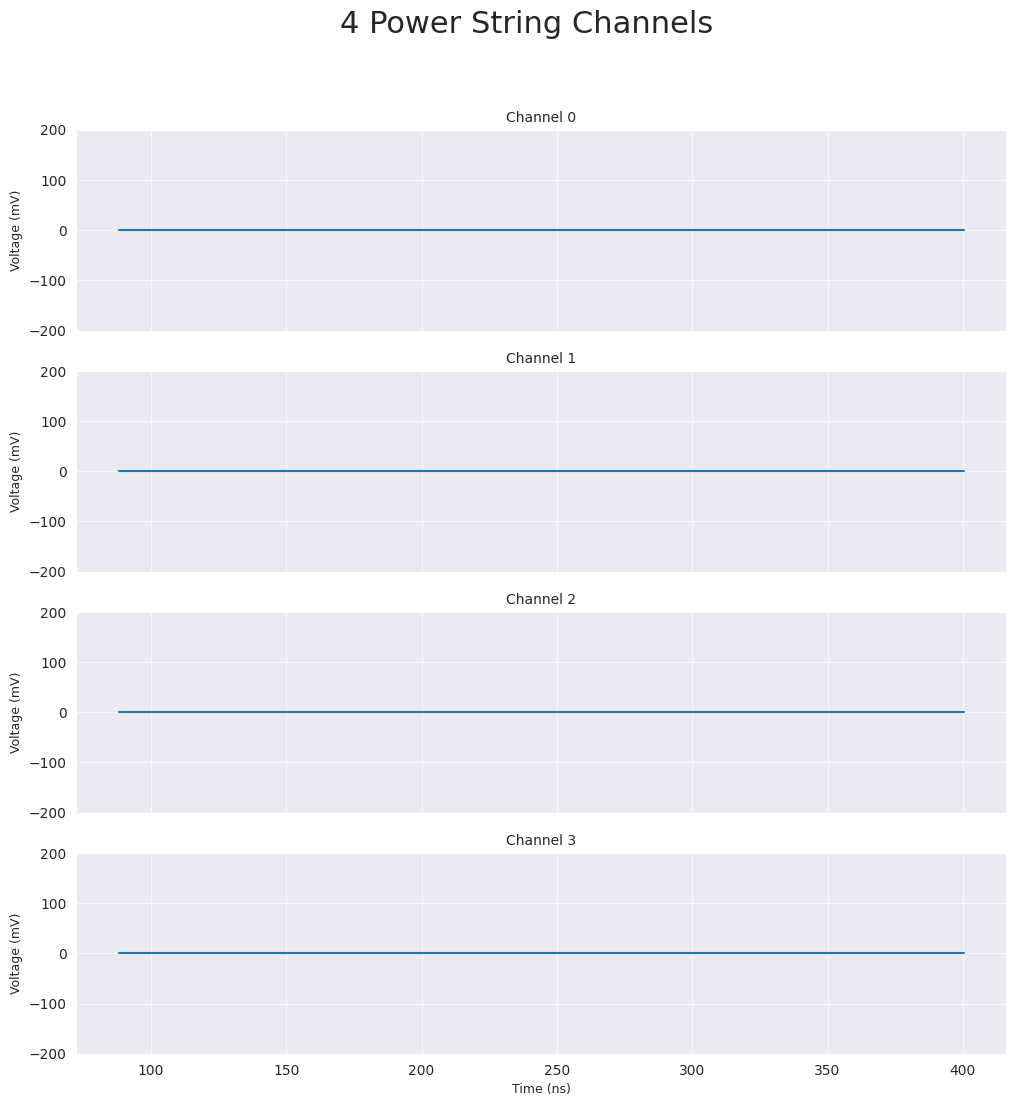

Phased SUMMED plot at t = 400.4070599999902
--------------------------------------------------------


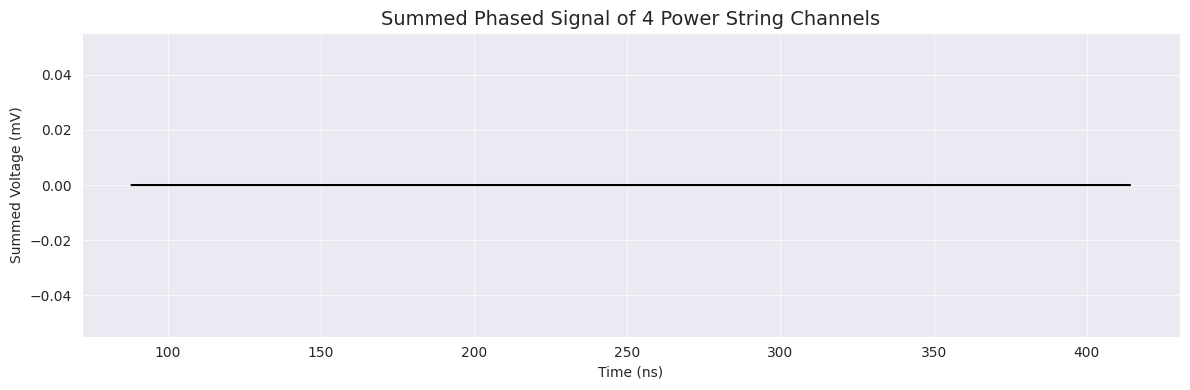

plot n°:  2.0
--------------------------------------------------------


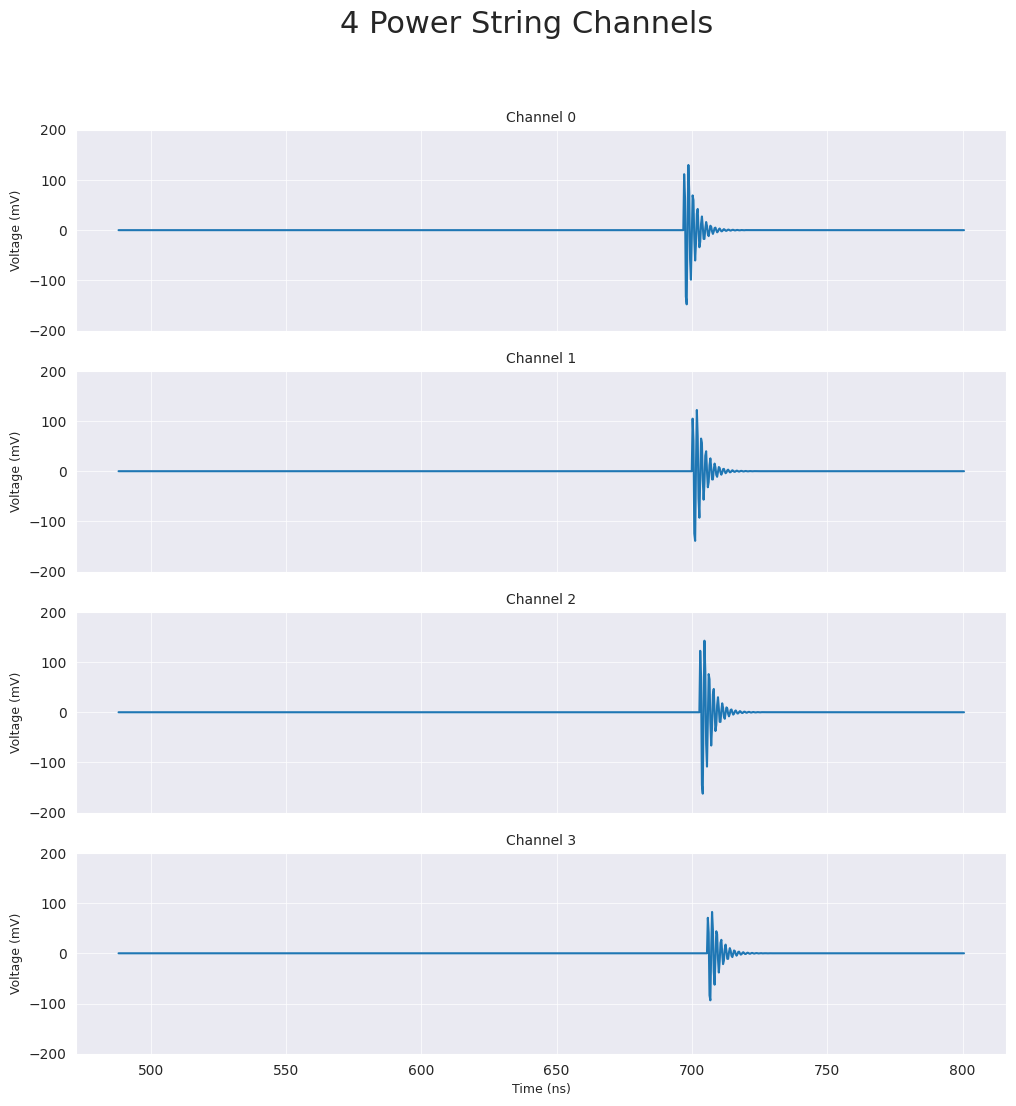

Phased SUMMED plot at t = 800.5017899999575
--------------------------------------------------------


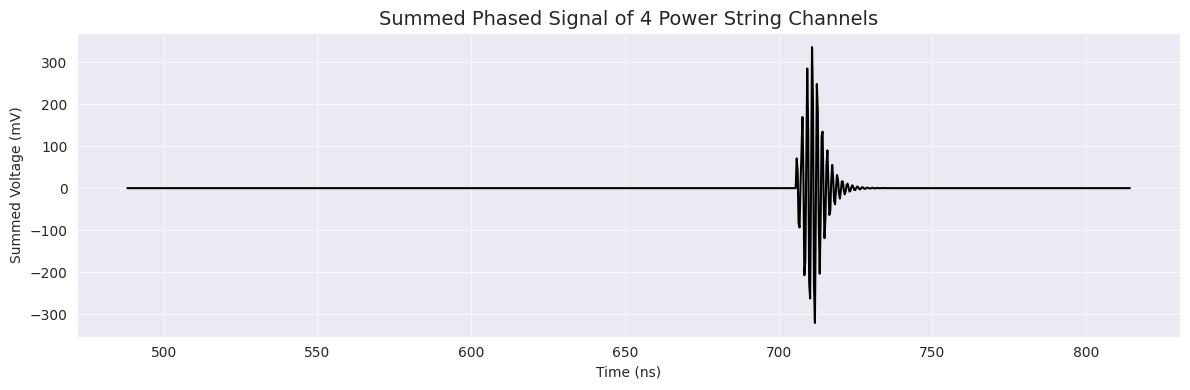

plot n°:  3.0
--------------------------------------------------------


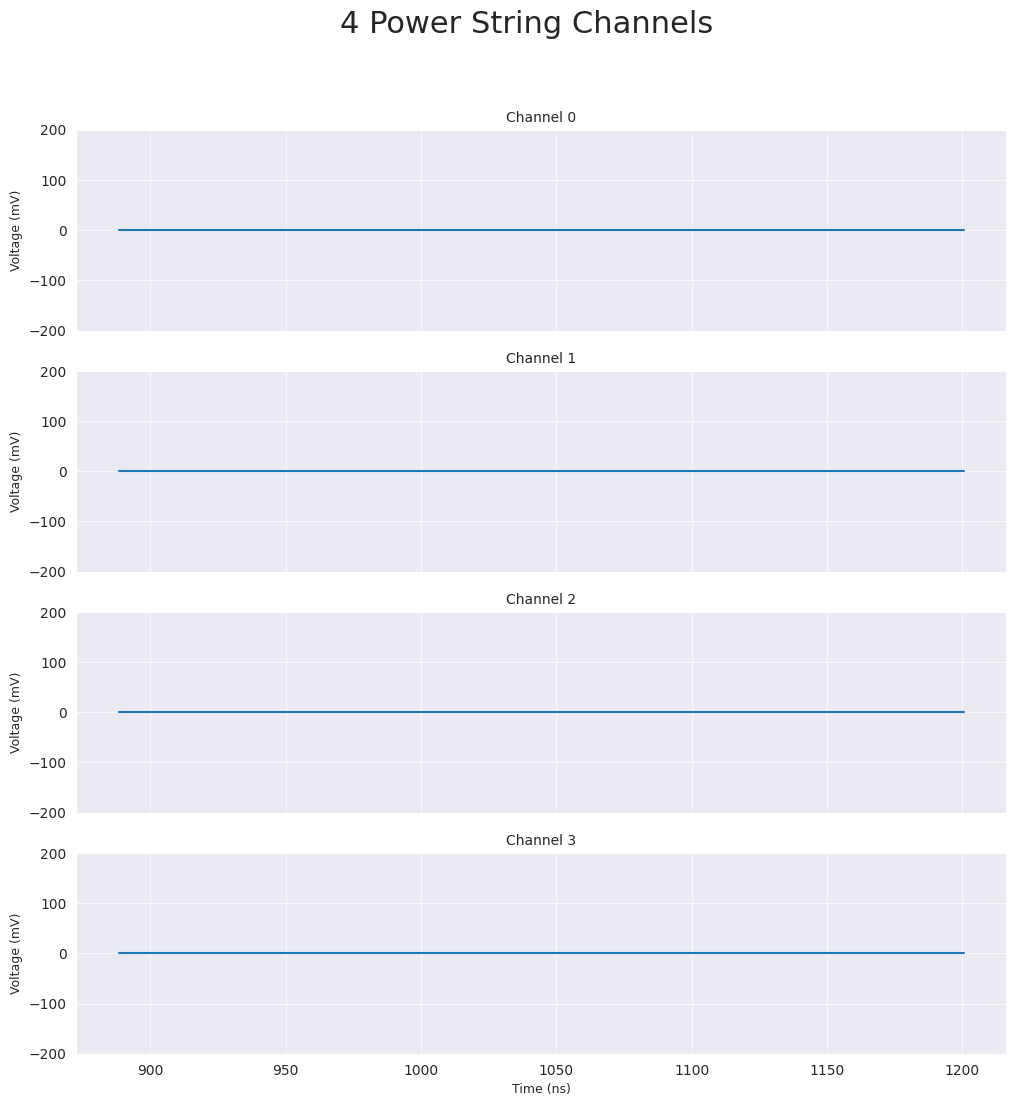

Phased SUMMED plot at t = 1200.5965199999248
--------------------------------------------------------


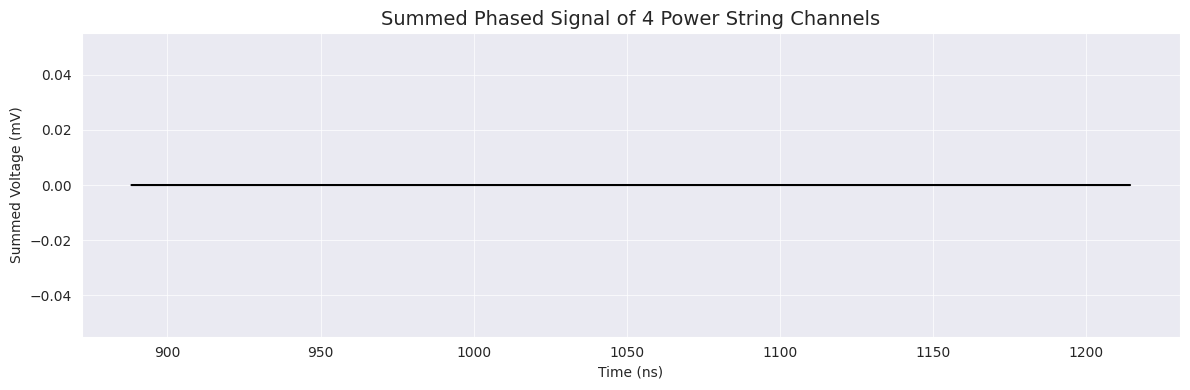

plot n°:  4.0
--------------------------------------------------------


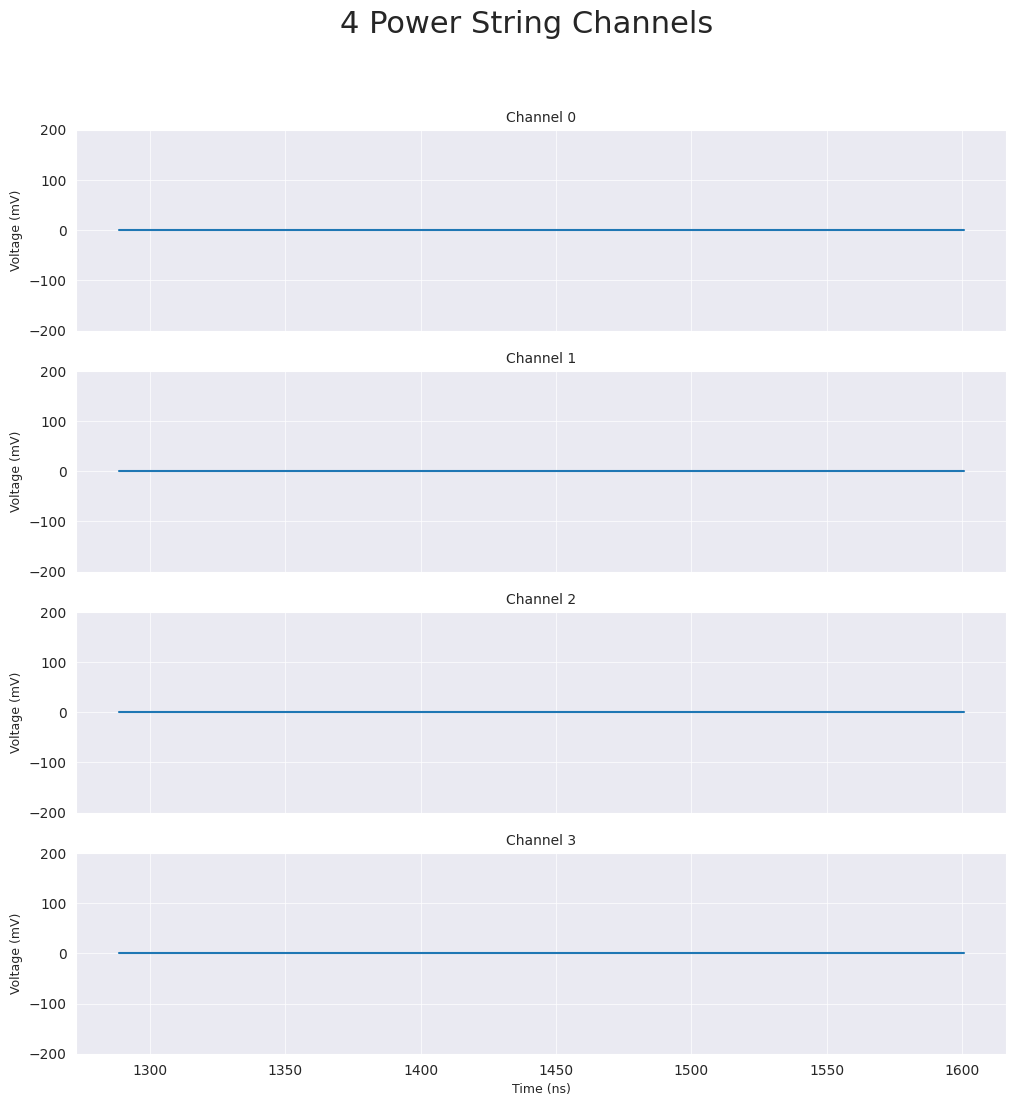

Phased SUMMED plot at t = 1600.691249999892
--------------------------------------------------------


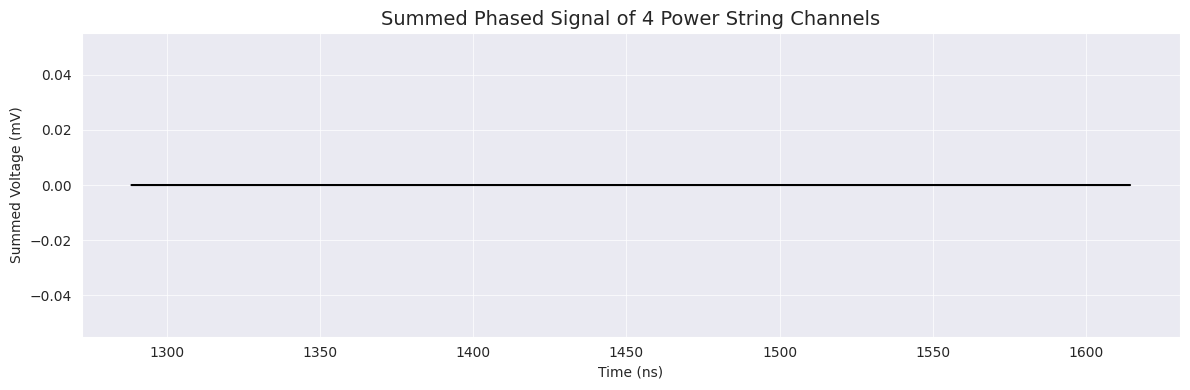

Done!


In [14]:
"""Compiler """

t_axis = np.array([0]) #This is the general time axis that is common for all channels
threshold_list=np.ones(n_of_channels) * COMMON_THRESHOLD
pulse_amplitudes, wave_counts, pulse_existence, pulse_delay_tracker= [], [], [], []  #the conditions that help track the progression of the signals using the classes

for i in range(n_of_channels): #this creates elements from the classes to keep track of the progression of the waveforms

    pulse_amplitudes.append(WaveAmplitude())
    wave_counts.append(WaveProgression())
    pulse_existence.append(PulseExistence())
    pulse_delay_tracker.append(WaveProgression())

#l_s and l_1s are lists that hold the binary values for the trigger L states
L_s=[np.array([]) for i in range(7)]  #the magic number 7 is for all (4: L2 triggers) + (2: L3 triggers) + (1: L4 triggers)
L_1s= [np.array([]) for i in range (n_of_channels)]

signals= [np.array([0]) for i in range (n_of_channels)] #generate empty arrays for the different channels

pulse_start_condition= PulseExistence()
pulse_time_delays= TimeDelay()
channel_triggered_once = [False] * n_of_channels

envelopes=[] #generate empty arrays for the different channels
for i in range(n_of_channels):
    envelopes.append(np.array([0 for _ in range(ENVELOPE_RANGE//2-1)]))
ind=0
#while True:
while ind < simulation_duration_ns: #choosing the number of plots to plot, replace by "while Tru"e to keep going until stopped

    t_axis= smart_append( t_axis, t_axis[-1]+SAMPLING_RATE, max_size) #adds +1 to time each cycle, and limits the len(t_axis) to max_size


    for n in range(n_of_channels): #this generates signals for the different channels
        new_data_point = signal_generator(NOISE_MEAN, NOISE_STD_DEV, pulse_existence, wave_counts, pulse_amplitudes, PULSE_LIKELIHOOD, PULSE_DURATION, pulse_start_condition, pulse_time_delays, graph_size_ns,pulse_delay_tracker, n, channel_triggered_once )


        signals[n] = smart_append( signals[n], new_data_point, max_size)

        if len(signals[n])>=ENVELOPE_RANGE:
            envelope_point=envelope(signals[n],ENVELOPE_RANGE)
            envelopes[n]=smart_append( envelopes[n], envelope_point, max_size)

    #there are two blocks of code in here
    """
    #block 1 for plotting L2 - L4 states
    # comment out the block needed for the desired trigger plots, also choose to save or show the plots
    L_states=L_Triggers(envelopes, L1, L1_counters, threshold_list, DELAY_PERIOD,L2,L2_level,L3,L4, Groups)


    for j in range (7):
        L_s[j]=smart_append(L_s[j],L_states[j],max_size)
    plot_L_states(t_axis,L_s, L_name, plot_size,graph_state,graph_save_name )


    #block 2 for plotting only L1 states
    L1s=L1_Triggers_returns(signals, L1, L1_counters, threshold_list, DELAY_PERIOD)

    for j in range (16):
        L_1s[j]=smart_append(L_1s[j],L1s[j],max_size)
    plot_L_states(t_axis,L_1s, L1_names, plot_size,time_delay_tracker)
    """

    """if there are some issues with the trigger, go back to the cell where L1, L2, L3 and L4 are defined and reset them"""


    #this function displays the waveforms
    #display_n_plots(t_axis, signals, plot_size) #function to plot the channels
    display_n_plots_envelope(t_axis,signals,COMMON_THRESHOLD,graph_size_ns,envelopes,PLOT_Y_LIMS,ENVELOPE_RANGE,graph_state,graph_save_name)
    #display_and_phase_channels(t_axis,signals,graph_size_ns, mode=graph_state ,name=graph_save_name )
    display_and_phase_summed(t_axis,signals,graph_size_ns,pulse_time_delays ,mode=graph_state ,name=graph_save_name )
    #phase_summed_analysis(t_axis,signals,graph_size_ns)
    ind+=SAMPLING_RATE
    time.sleep(0.000001) #delay condition to help prevent oveloading the processor/ not sure how helpful this is

print("Done!")
